In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

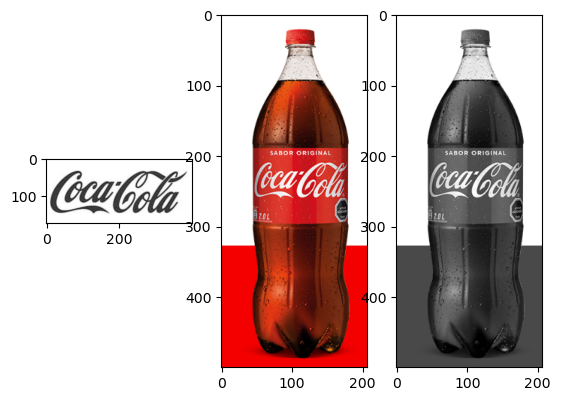

In [2]:
# Cargamos la imagen a procesar
img = cv.imread('images/coca_logo_1.png')

img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
template = cv.imread('template/pattern.png',0)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(template, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_rgb)
plt.subplot(1,3,3)
plt.imshow(img_gray, cmap='gray')

cv.waitKey()
cv.destroyAllWindows()

In [3]:

print('\nTamaño imagen: {} pix'.format(template.shape))

#Nivel 1
template_nivel_1 = cv.pyrDown(template)
print('\nTamaño imagen: {} pix'.format(template_nivel_1.shape))

#Nivel 2
template_nivel_2 = cv.pyrDown(template_nivel_1)
print('\nTamaño imagen: {} pix'.format(template_nivel_2.shape))

#Nivel 3
template_nivel_3 = cv.pyrDown(template_nivel_2)
print('\nTamaño imagen: {} pix'.format(template_nivel_3.shape))

# Muestro los resultados
# cv.imshow("Template Original", template)
# cv.imshow("Template Nivel 1", template_nivel_1)
# cv.imshow("Template Nivel 2", template_nivel_2)
# cv.imshow("Template Nivel 3", template_nivel_3)

# cv.waitKey()
# cv.destroyAllWindows()


Tamaño imagen: (175, 400) pix

Tamaño imagen: (88, 200) pix

Tamaño imagen: (44, 100) pix

Tamaño imagen: (22, 50) pix


In [15]:
cv.Canny(template, threshold1=5, threshold2=200)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [17]:
cv.imshow('img_gray_inv', cv.Canny(template_nivel_1, threshold1=5, threshold2=200))
cv.imshow('img_gray',cv.Canny(img_gray, threshold1=5, threshold2=200))
cv.imshow("Template Nivel 1", template_nivel_1)
cv.waitKey()
cv.destroyAllWindows()

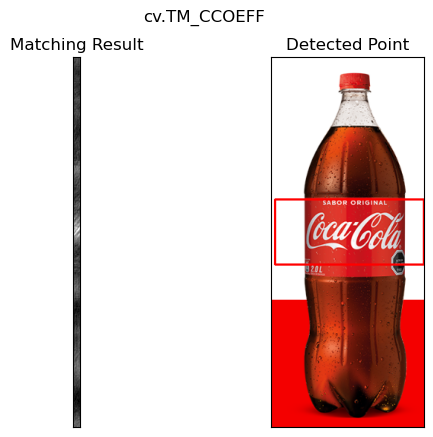

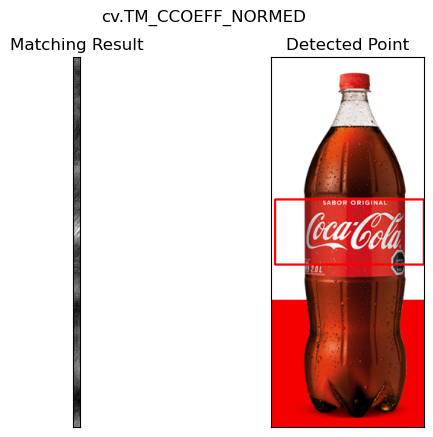

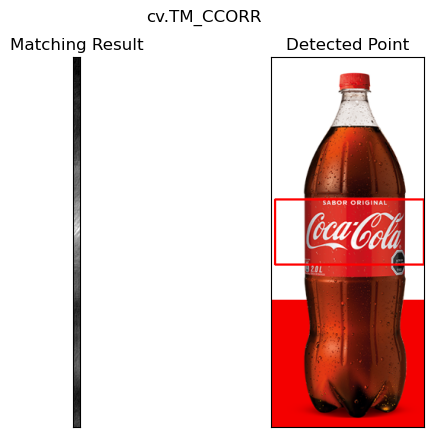

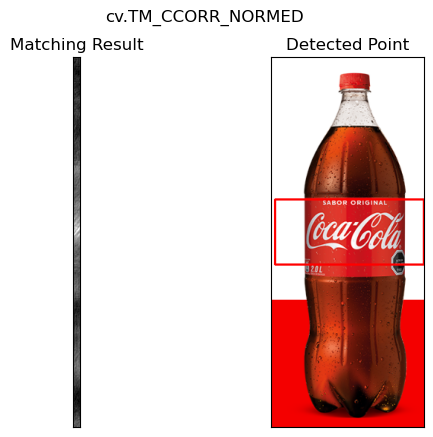

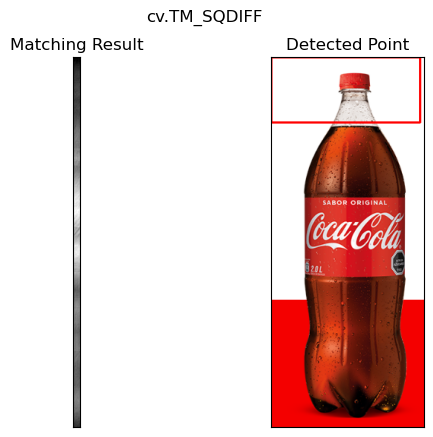

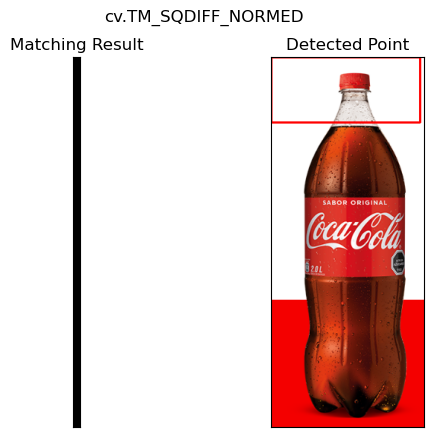

In [18]:
template = cv.Canny(template_nivel_1, threshold1=5, threshold2=200)
img_gray = cv.Canny(img_gray, threshold1=5, threshold2=200)
w, h = template.shape[::-1]
# Los 6 métodos posibles para comparación:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

for meth in methods:
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img_rgb.copy()
    
    method = eval(meth)
    
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    res = cv.matchTemplate(img_gray, template, method)
    
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida,top_left, bottom_right, 255, 2)
    
    # Graficamos el procesamiento y la salida
    #----------------------------------------
    plt.figure()
    
    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    
    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    
    plt.suptitle(meth)
    plt.show()

    cv.waitKey()
    cv.destroyAllWindows()